# 1.导入数据加载数据

In [2]:
import matplotlib.pyplot as plt
import glob
from collections import namedtuple
import numpy as np
import cv2
np.random.seed(101)
%matplotlib inline

In [4]:
N_CLASSES = 43
RESIZED_IMAGE = (32, 32)

In [3]:
#定义元组
Dataset = namedtuple('Dataset', ['X', 'y'])

In [19]:
def to_tf_format(imgs):
    return np.stack([img[:, :, np.newaxis] for img in imgs], axis=0).astype(np.float32)

In [20]:
def read_dataset_ppm(rootpath, n_labels, resize_to):
    """
    读取数据
    """
    images = []
    labels = []
    for c in range(n_labels):
        full_path = rootpath + '/' + format(c, '05d') + '/'
        for img_name in glob.glob(full_path + "*.ppm"):
            img = cv2.imread(img_name)
            img = cv2.resize(img,RESIZED_IMAGE, 0, 0, cv2.INTER_LINEAR)
            img = img.astype(np.float32)
            img = np.multiply(img, 1.0 / 255.0)  #进行归一化
            img = np.mean(img, -1)  #进行灰度
            
            images.append(img.astype(np.float32))
            label = np.zeros((n_labels, ), dtype=np.float32)
            label[c] = 1.0
            labels.append(label)
            
    return Dataset(X = to_tf_format(images).astype(np.float32),
                  y = np.matrix(labels).astype(np.float32))


In [21]:
dataset = read_dataset_ppm('./GTSRB/Final_Training/Images/', N_CLASSES, RESIZED_IMAGE

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


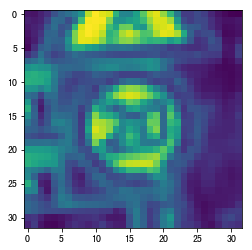

In [51]:
plt.imshow(dataset.X[0, :, :, :].reshape(RESIZED_IMAGE)) 
print(dataset.y[-1, :]) #label

In [52]:
#切分训练集与测试集，切分索引号
from sklearn.model_selection import train_test_split
idx_train, idx_test = train_test_split(range(dataset.X.shape[0]), test_size=0.25, random_state=101)
X_train = dataset.X[idx_train, :, :, :]
X_test = dataset.X[idx_test, :, :, :]
y_train = dataset.y[idx_train, :]
y_test = dataset.y[idx_test, :]

#打印维度
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)      

(29406, 32, 32, 1)
(29406, 43)
(9803, 32, 32, 1)
(9803, 43)


In [53]:
#定义minibatcher函数
def minibatcher(X, y, batch_size, shuffle):
    assert X.shape[0] == y.shape[0]
    n_samples = X.shape[0]
    
    if shuffle:
        idx = np.random.permutation(n_samples)
    else:
        idx = list(range(n_samples))
    
    for k in range(int(np.ceil(n_samples/batch_size))):
        from_idx = k * batch_size
        to_idx = (k+1) * batch_size
        yield X[idx[from_idx:to_idx], :, :, :], y[idx[from_idx:to_idx], :]
        

# 建立网络层

In [42]:
import tensorflow as tf

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [55]:
#定义初始化函数
def fc_no_activation_layer(in_tensors, n_units):
  w = tf.get_variable('fc_W', 
    [in_tensors.get_shape()[1], n_units],
    tf.float32,
    tf.contrib.layers.xavier_initializer())
  b = tf.get_variable('fc_B',
    [n_units, ],
    tf.float32,
    tf.constant_initializer(0.0))
  return tf.matmul(in_tensors, w) + b

def fc_layer(in_tensors, n_units):
  return tf.nn.leaky_relu(fc_no_activation_layer(in_tensors, n_units))

def maxpool_layer(in_tensors, sampling):
  return tf.nn.max_pool(in_tensors, [1, sampling, sampling, 1], [1, sampling, sampling, 1], 'SAME')
  
def conv_layer(in_tensors, kernel_size, n_units):
  w = tf.get_variable('conv_W', 
    [kernel_size, kernel_size, in_tensors.get_shape()[3], n_units],
    tf.float32,
    tf.contrib.layers.xavier_initializer())
  b = tf.get_variable('conv_B',
    [n_units, ],
    tf.float32,
    tf.constant_initializer(0.0))
  return tf.nn.leaky_relu(tf.nn.conv2d(in_tensors, w, [1, 2, 2, 1], 'SAME') + b)

In [56]:
def traffic_cnn(in_tensors):
    """
    构建三层卷积
    """
    
    #第一层
    with tf.variable_scope('l1'):
        l1 = maxpool_layer(conv_layer(in_tensors, 5, 64), 2)
        l1_out = tf.nn.dropout(l1,keep_prob=0.7)
        
    #第二层
    with tf.variable_scope('l2'):
        l2 = maxpool_layer(conv_layer(l1_out, 5, 128), 2)
        l2_out = tf.nn.dropout(l2,keep_prob=0.7)
    
    #第三层
    with tf.variable_scope('l3'):
        l3 = maxpool_layer(conv_layer(l2_out, 5, 512), 2)
        l3_out = tf.nn.dropout(l3,keep_prob=0.7)
    
    with tf.variable_scope('flatten'):
        l3_out_flat = tf.layers.flatten(l3_out)
    #全连接
    with tf.variable_scope('fc'):
        fc = fc_layer(l3_out_flat, 1024)
        fc_out = tf.nn.dropout(fc, keep_prob=0.6)
    
    with tf.variable_scope('out'):
        out_tensors = fc_no_activation_layer(fc_out, N_CLASSES)
    return out_tensors

In [57]:
from sklearn.metrics import classification_report, confusion_matrix

In [61]:
def train_model(X_train, y_train, X_test, y_test, learning_rate, max_epochs, batch_size):
    X = tf.placeholder(tf.float32,shape=(None,RESIZED_IMAGE[0],RESIZED_IMAGE[1],1))
    y = tf.placeholder(tf.float32,shape=(None, N_CLASSES))
    
    out = traffic_cnn(X)
    predict = tf.nn.softmax(out)
    loss_score = tf.nn.softmax_cross_entropy_with_logits(logits=out, labels=y)
    loss = tf.reduce_mean(loss_score)
    optimizer = tf.train.AdadeltaOptimizer(learning_rate).minimize(loss)
    predict_cls = tf.argmax(predict,axis=1)
    Y_cls = tf.argmax(y,axis=1)
    correct_pred = tf.equal(predict_cls,Y_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    #保存模型
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        step = 0
        
        for epoch in range(max_epochs):
            print("Epoch=",epoch)
            tf_score = []
            for mb in minibatcher(X_train, y_train, batch_size, shuffle = True):
                tf_output  = sess.run([optimizer,loss],
                                      feed_dict = {X : mb[0],
                                                   y : mb[1]
                                                  })
                tf_score.append(tf_output[1])
                step += 1
            print("train_loss_score=",np.mean(tf_score))

            #一轮完了测试准确率
            for mb_test in minibatcher(X_test, y_test, batch_size,shuffle = True):
                acc = sess.run(accuracy, feed_dict={X : mb_test[0],y : mb_test[1]})
                print('epoch:',epoch,'acc:',acc)
                if acc > 0.99:
                    saver.save(sess,'./model/traffic.model',global_step=step)

        print('TEST SET PERFORMANCE')
        y_test_pred, test_loss  = sess.run([predict, loss], 
                                      feed_dict = {X : X_test, 
                                                   y : y_test})
        print('test_loss_score=',test_loss)
        y_test_pred_classified , y_test_true_classified =sess.run([predict_cls , Y_cls],
                                                                 feed_dict = {X : X_test,
                                                                             y : y_test})

        print(classification_report(y_test_true_classified, y_test_pred_classified))

        cm = confusion_matrix(y_test_true_classified,y_test_pred_classified)

        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.colorbar()
        plt.tight_layout()
        plt.show()

        # And the log2 version, to enphasize the misclassifications
        plt.imshow(np.log2(cm + 1), interpolation='nearest', cmap=plt.get_cmap("tab20"))
        plt.colorbar()
        plt.tight_layout()
        plt.show()

In [62]:
tf.reset_default_graph()

In [63]:
train_model(X_train, y_train, X_test, y_test, 0.001, 1000, 32)

Epoch= 0
train_loss_score= 3.759614


NameError: name 'Y' is not defined